1. Loading Data

In [13]:
import pandas as pd

df = pd.read_csv('transactional-sample.csv')
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   object        
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   float64       
 7   has_cbk             3199 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 178.2+ KB
None


2. Data Preparation

This time, we are going to include two columns in our data. Both are derived from the date of the transaction: day of week and hour of day. In our data exploration phase that it is more likely to have fraudulent transactions between 16hs and 23hs. Also, there is a lower chance to have fraudulent transactions in Mondays and Tuesdays.

These columns may help improve the model accuracy.

In [14]:
# Create columns for day of the week and hour of day
df['day_of_week'] = df['transaction_date'].dt.dayofweek
df['hour_of_day'] = df['transaction_date'].dt.hour

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   object        
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   float64       
 7   has_cbk             3199 non-null   bool          
 8   day_of_week         3199 non-null   int32         
 9   hour_of_day         3199 non-null   int32         
dtypes: bool(1), datetime64[ns](1), float64(2), int32(2), int64(3), object(1)
memory usage: 203.2+ KB
None


In [15]:
from sklearn.model_selection import train_test_split

# Drop irrelevant or high-cardinality columns like transaction_id, card_number
X = df.drop(['has_cbk', 'transaction_id', 'card_number', 'transaction_date'], axis=1)
y = df['has_cbk']

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['merchant_id', 'device_id'], drop_first=True)

# Split the data (70% for training and 30% for testing)
# Also keeps the proportion of fraudulent and legit data
X_train, X_test, y_train, y_test = train_test_split(
  X, y,
  test_size=0.3,
  random_state=42,
  stratify=y
)

3. Modelling

In [16]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

4. Evaluation

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       False       0.94      0.99      0.97       843
        True       0.92      0.56      0.69       117

    accuracy                           0.94       960
   macro avg       0.93      0.77      0.83       960
weighted avg       0.94      0.94      0.93       960



The model achieved 94% accuracy.

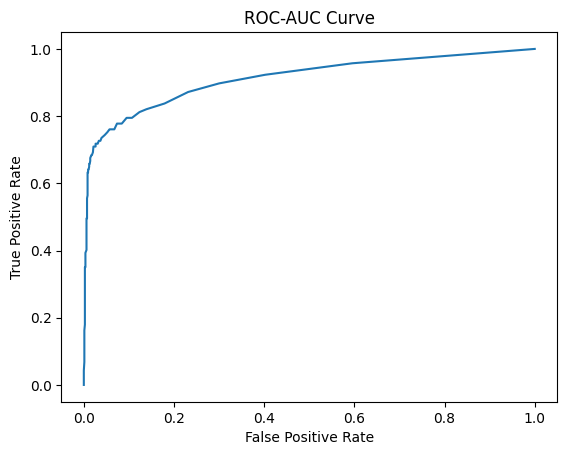

In [18]:
# ROC-AUC curve
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

According to the curve, the model has a good overall performance (above the diagonal, which would be the same as flipping a coin).

In [19]:
print("ROC AUC Score: ", roc_auc_score(y_test, y_proba))

ROC AUC Score:  0.9118684794841379


This score suggests that there is a 91.18% chance that the model will correctly distinguish between a randomly chosen positive instance (e.g., a fraudulent transaction) and a randomly chosen negative instance (e.g., a legitimate transaction). Adding the day of week and the hour of day helped to improve this score.